# 1D Diffusion Equation

In this notebook, we will use the **Forward Time Centered Space** (FTCS) scheme to solve the 1D partial differential equation for diffusion:

$$ \frac{\partial \theta}{\partial t} = \kappa \frac{\partial^{2}\theta}{\partial x^{2}} $$

where $\theta$ is some scalar or vector tracer, such as temperature, salinity, dye concentration, hydraulic head, or velocity, and $\kappa$ is the diffusion coefficient (diffusivity) of the material. In the work below, we assume diffusion is isotropic, and diffusivity is thus constant and uniform, and that we are modeling heat conduction in a 1D metal rod.

As the name implies, the FTCS scheme uses a forward Euler method to approximate the temporal derivative and a centered method to approximate the spatial derivative in the 1D diffusion equation, as:

$$ T_{j}^{k+1} = s(T_{j+1}^{k} + T_{j-1}^{k}) + (1-2s)T_{j}^{k} $$

where 

$$ s = \frac{\kappa \Delta t}{\Delta x^{2}} $$

To solve the diffusion equation for unique solutions, we will need to impose initial conditions and boundary conditions. Consider the general boundary conditions:

**Dirichlet**
$$ \text{Initial Condition: } T(x,t=0) = T_{j}^{0} = f(x_{j}) $$
$$ \text{Boundary Condition: } T(x=0,t) = T_{0}^{k} = g_{1}(t^{k}) $$

**Neumann**
$$ \text{Boundary Condition: } \frac{\partial T(L,t)}{\partial x} = \frac{\partial T_{n+1}^{k}}{\partial x} = g_{2}(t^{k}) $$

which can be simplified and written as:
$$ T_{n+1}^{k} = \Delta x g_{2}(t^{k}) + T_{n}^{k} $$

where $f$, $g_{1}$, and $g_{2}$ are arbitrary functions.
***

The numerical implementation of the FTCS scheme (and other schemes we will implement from here on out in class) rely on formulating the FTCS equation above in matrix form. For example, for a spatial grid with 3 internal points $x_{0}$, $x_{1}$, $x_{2}$, $x_{3}$, $x_{4}$ where $x_{0}$ and $x_{4}$ are boundary locations. The solution for these spatial points at a given time $k+1$ can be expressed in matrix form as:

$$ \bar{T}^{k+1} = \begin{bmatrix}
T_{1}^{k+1} \\ T_{2}^{k+1} \\ T_{3}^{k+1}
\end{bmatrix} = \begin{bmatrix}
1-2s & s & 0 \\
s & 1-2s & s \\
0 & s & 1-2s
\end{bmatrix} \begin{bmatrix}
T_{1}^{k} \\ T_{2}^{k} \\ T_{3}^{k}
\end{bmatrix} + \begin{bmatrix}
sT_{0}^{k} \\ 0 \\ sT_{4}^{k}
\end{bmatrix} $$

Substituting in the boundary conditions defined above:

$$ \bar{T}^{k+1} = \begin{bmatrix}
T_{1}^{k+1} \\ T_{2}^{k+1} \\ T_{3}^{k+1}
\end{bmatrix} = \begin{bmatrix}
1-2s & s & 0 \\
s & 1-2s & s \\
0 & s & 1-s
\end{bmatrix} \begin{bmatrix}
T_{1}^{k} \\ T_{2}^{k} \\ T_{3}^{k}
\end{bmatrix} + \begin{bmatrix}
sg_{1}(t^{k}) \\ 0 \\ s\Delta x g_{2}(t^{k})
\end{bmatrix} $$

or

$$ \bar{T}^{k+1} = A\bar{T}^{k+1} + B $$

This formulation is how we will implement the FTCS scheme.

In [17]:
import numpy as np
import matplotlib.pyplot as plt

First, define the solution space and parameters, and initialize the matrices.

In [18]:
# dimensions of the rod
x0 = 0
xL = 1
L = xL-x0

# number of nodes to discretize the x dimension
n = 39
dX = L/(n+1)

# number of time steps
m = 600
T = 12000 # total time
dT = T/m

# diffusivity
kappa = 10**(-5)

# define s
s = kappa*dT/(dX**2)
print('s = ',s)

s =  0.31999999999999995


In [19]:
# initialize the matrix A and vector B
A = np.zeros((n,n))

for i in range(n):
    if i == 0:
        A[i, i] = 1-(2*s)
        A[i, i+1] = s
    elif i == n-1:
        A[i, i-1] = s
        A[i, i] = 1-(2*s)
    else:
        A[i, i] = 1-(2*s)
        A[i, i-1] = s
        A[i, i+1] = s

B = np.zeros((n, 1))

Next, impose boundary conditions.

In [20]:
# apply Dirichlet BCs
B[0] = s
B[n-1] = s

# apply Neumann BCs
#A[n-1, n-1] = 1-s
#B[n-1] = 2*s*dX

Create the spatial discretization.

In [21]:
x = np.arange(x0+dX,xL,dX)
t0 = 0

Impose and plot initial conditions.

Text(0, 0.5, 'T(0)')

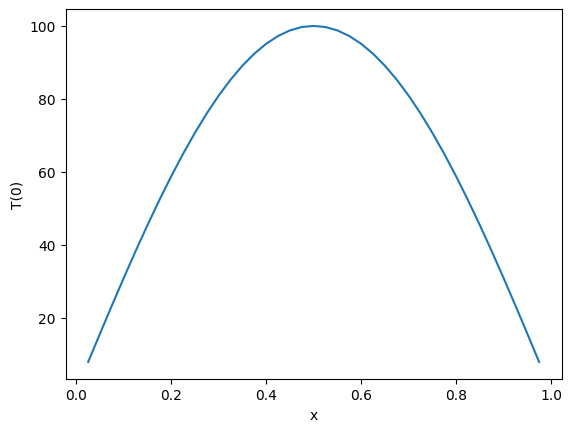

In [22]:
U_xt = 100*np.sin(np.pi*x/L)

fig, ax = plt.subplots(1)
ax.plot(x, U_xt)
ax.set_xlabel('x')
ax.set_ylabel('T(0)')

Initialize solution matrices.

In [23]:
U = np.zeros((m,n))
U[0, :] = U_xt
t = np.zeros((m))
t[0] = t0

Finally, march forward in time (with some probably unnecessary shape-shifting).

In [24]:
# March in time
for i in range(m-1):
    U_xt_n = np.matmul(A, U_xt[:, np.newaxis]) + B
    U[i+1, :] = U_xt_n.flatten()
    U_xt = U_xt_n.flatten()
    t[i+1] = t[i] + dT    

Plot the results!

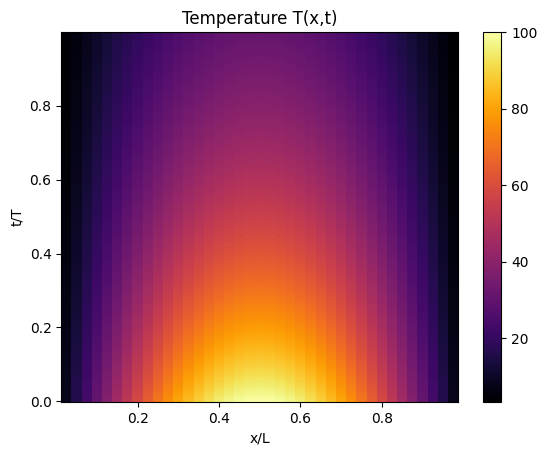

In [25]:
fig, ax = plt.subplots(1)
c = ax.pcolormesh(x, t/T, U, cmap='inferno')
ax.set_xlabel('x/L')
ax.set_ylabel('t/T')
ax.set_title('Temperature T(x,t)'
)
plt.colorbar(c)